In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.4.0

# install spark-nlp
%pip install spark-nlp==5.1.3

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.11.17         |  py310h06a4308_0         158 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/

## Need Restart Kernal

In [1]:
import json
import sparknlp
import numpy as np
import pandas as pd
from sparknlp.base import *
from pyspark.ml import Pipeline
from sparknlp.annotator import *
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from sparknlp.pretrained import PretrainedPipeline
from pyspark.sql.functions import expr, col
from pyspark.sql.functions import count

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import from_unixtime

# Import pyspark and build Spark session
spark = SparkSession.builder \
    .appName("Spark NLP")\
    .master("local[*]")\
    .config("spark.driver.memory","16G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3")\
    .getOrCreate()

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-262176cd-4c8c-4b6b-a4c3-317d083182fe;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.1.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.20.1 in central
	found com.google.guava#guava;31.1-jre in central
	found com.google.guava#failureaccess;1.0.1 

In [2]:
# Read Data
df = spark.read.parquet("data/iphone_related_submissions.parquet")

In [3]:
# This will return a statistical summary of the score, including count, mean, stddev, min, max
# df.describe("score").show()

In [8]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

#Create a feature vector containing scores and number of reviews
assembler = VectorAssembler(inputCols=["score", "num_comments"], outputCol="features")
df_assembled = assembler.transform(df)

#Initialize the decision tree regression model
dt = DecisionTreeRegressor(featuresCol="features", labelCol="score")

# Divide the data set into training set and test set
(train_data, test_data) = df_assembled.randomSplit([0.8, 0.2], seed=42)

#Train model
dt_model = dt.fit(train_data)

# Make predictions on the test set
predictions = dt_model.transform(test_data)

# Evaluate model performance
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

# Use the entire data set for regression model training
final_dt_model = dt.fit(df_assembled)

# Make predictions on the entire dataset to get popularity scores
df_final = final_dt_model.transform(df_assembled)

# Determine the 75% percentile of the popularity score as the threshold for popular posts
popularity_threshold = df_final.approxQuantile("prediction", [0.75], 0.05)[0]

# Mark data based on threshold
df_popularity = df_final.withColumn('label', (col('prediction') > popularity_threshold).cast('integer'))

#Select the original data column and the new label column
df_popularity = df_popularity.select(*df.columns, 'label')

# Now df_popularity contains a label column that can be used for classification model training

Root Mean Squared Error (RMSE) on test data = 158.2869996064095


In [19]:
# Feature Engineering
from pyspark.sql.functions import hour, dayofweek, year

# Convert Unix timestamp to readable date format
df_feature = df_popularity.withColumn('created_utc', from_unixtime('created_utc').cast('timestamp'))

# Extract the hour and week when the post was published
df_feature = df_feature.withColumn('hour', hour(col('created_utc')))
df_feature = df_feature.withColumn('day_of_week', dayofweek(col('created_utc')))
df_feature = df_feature.withColumn('year', year(col('created_utc')))

# Limit data from 2018 to 2023
df_feature = df_feature.filter(year(col('created_utc')).between(2018, 2023))

# Convert boolean type features to integer type
bool_to_int = udf(lambda x: 1 if x else 0, IntegerType())
df_feature = df_feature.withColumn('is_self_int', bool_to_int(col('is_self')))
df_feature = df_feature.withColumn('over_18_int', bool_to_int(col('over_18')))
df_feature = df_feature.withColumn('stickied_int', bool_to_int(col('stickied')))
df_feature = df_feature.withColumn('locked_int', bool_to_int(col('locked')))
df_feature = df_feature.withColumn('edited_int', bool_to_int(col('edited').isNotNull()))

# Preprocess text data
# Participle
regexTokenizer = RegexTokenizer(inputCol="title", outputCol="words", pattern="\\W")

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

# Calculate TF-IDF
countVectorizer = CountVectorizer(inputCol="filtered_words", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")

In [20]:
# Feature vector assembly
assemblerInputs = ['hour', 'day_of_week', 'is_self_int', 'over_18_int', 'stickied_int', 'locked_int', 'edited_int', 'features'] 
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features_vector")

# Build preprocessed Pipeline
pipeline = Pipeline(stages=[
    regexTokenizer,
    remover,
    countVectorizer,
    idf,
    assembler
])

# Apply Pipeline for data conversion
pipelineModel = pipeline.fit(df_feature)
df_transformed = pipelineModel.transform(df_feature)

# Select the required columns
df_feature = df_transformed.select('features_vector', 'label')

In [21]:
# Train Models
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline

# Divide the data set into training set and validation set
(training_data, validation_data) = df_feature.randomSplit([0.8, 0.2], seed=42)

# Initialize different models
lr = LogisticRegression(featuresCol='features_vector', labelCol='label')
rf = RandomForestClassifier(featuresCol='features_vector', labelCol='label')
gbt = GBTClassifier(featuresCol='features_vector', labelCol='label')

# Train model
lr_model = lr.fit(training_data)
rf_model = rf.fit(training_data)
gbt_model = gbt.fit(training_data)

23/11/30 05:10:14 WARN DAGScheduler: Broadcasting large task binary with size 1401.3 KiB
23/11/30 05:10:16 WARN DAGScheduler: Broadcasting large task binary with size 1402.4 KiB
23/11/30 05:10:17 WARN DAGScheduler: Broadcasting large task binary with size 1401.8 KiB
23/11/30 05:10:19 WARN DAGScheduler: Broadcasting large task binary with size 1403.0 KiB
23/11/30 05:10:19 WARN DAGScheduler: Broadcasting large task binary with size 1401.8 KiB
23/11/30 05:10:20 WARN DAGScheduler: Broadcasting large task binary with size 1403.0 KiB
23/11/30 05:10:20 WARN DAGScheduler: Broadcasting large task binary with size 1401.8 KiB
23/11/30 05:10:20 WARN DAGScheduler: Broadcasting large task binary with size 1403.0 KiB
23/11/30 05:10:20 WARN DAGScheduler: Broadcasting large task binary with size 1401.8 KiB
23/11/30 05:10:20 WARN DAGScheduler: Broadcasting large task binary with size 1403.0 KiB
23/11/30 05:10:20 WARN DAGScheduler: Broadcasting large task binary with size 1401.8 KiB
23/11/30 05:10:21 WAR

In [22]:
# 模型优化和验证
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# 创建逻辑回归的参数网格
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [10, 20]) \
    .build()

# 设置逻辑回归的交叉验证
crossval_lr = CrossValidator(estimator=lr,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=BinaryClassificationEvaluator(labelCol="label"),
                             numFolds=5)

# 运行交叉验证来选择最佳参数集
cv_model_lr = crossval_lr.fit(training_data)

# 使用最佳模型对验证集进行预测
predictions_lr = cv_model_lr.bestModel.transform(validation_data)

# 评估最佳模型
evaluator = BinaryClassificationEvaluator(labelCol="label")
auc = evaluator.evaluate(predictions_lr, {evaluator.metricName: "areaUnderROC"})

multi_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
accuracy = multi_evaluator.evaluate(predictions_lr)
f1 = multi_evaluator.evaluate(predictions_lr, {multi_evaluator.metricName: "f1"})

print(f"AUC: {auc}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

23/11/30 05:14:31 WARN DAGScheduler: Broadcasting large task binary with size 1415.8 KiB
23/11/30 05:14:34 WARN DAGScheduler: Broadcasting large task binary with size 1416.9 KiB
23/11/30 05:14:34 WARN DAGScheduler: Broadcasting large task binary with size 1416.3 KiB
23/11/30 05:14:34 WARN DAGScheduler: Broadcasting large task binary with size 1417.5 KiB
23/11/30 05:14:34 WARN DAGScheduler: Broadcasting large task binary with size 1416.3 KiB
23/11/30 05:14:35 WARN DAGScheduler: Broadcasting large task binary with size 1417.5 KiB
23/11/30 05:14:35 WARN DAGScheduler: Broadcasting large task binary with size 1416.3 KiB
23/11/30 05:14:35 WARN DAGScheduler: Broadcasting large task binary with size 1417.5 KiB
23/11/30 05:14:35 WARN DAGScheduler: Broadcasting large task binary with size 1416.3 KiB
23/11/30 05:14:35 WARN DAGScheduler: Broadcasting large task binary with size 1417.5 KiB
23/11/30 05:14:35 WARN DAGScheduler: Broadcasting large task binary with size 1416.3 KiB
23/11/30 05:14:36 WAR

AUC: 0.5979153591350955
Accuracy: 0.7731365159128978
F1 Score: 0.6771646687851286


In [34]:
# Get the attributes that have the greatest impact on popularity in the logistic regression model
# Extract the coefficients of the logistic regression model
lr_coefficients = lr_model.coefficients.toArray()

# Match coefficients to feature names
feature_names = assembler.getInputCols()
coefficients_with_features = zip(feature_names, lr_coefficients)

# Sort the coefficients to find the most important features
sorted_coefficients = sorted(coefficients_with_features, key=lambda x: x[1], reverse=True)

# Print important features and corresponding coefficients
for feature, coef in sorted_coefficients:
    print(f"{feature}: {coef}")


stickied_int: 19.48034014033475
edited_int: 0.739907124805156
is_self_int: 0.2168240866027578
hour: 0.009130504845957588
day_of_week: -0.005687518937613438
features: -0.029843402129460316
locked_int: -0.6851923857361955
over_18_int: -0.7377361318639629


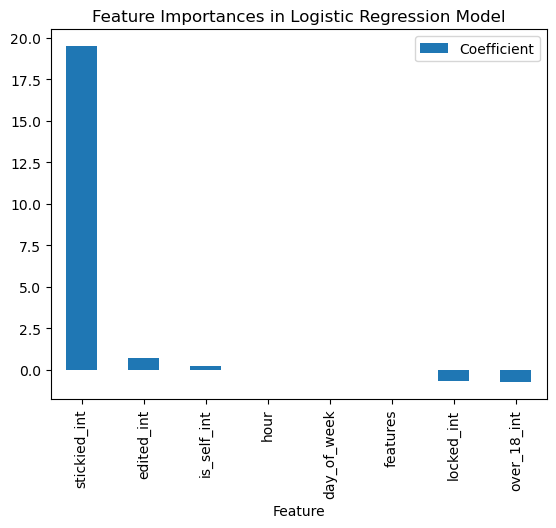

In [35]:
#Convert feature names and coefficients to DataFrame
import pandas as pd
coeff_df = pd.DataFrame(sorted_coefficients, columns=["Feature", "Coefficient"])

# Use Matplotlib to draw a bar chart
import matplotlib.pyplot as plt
coeff_df.plot(x="Feature", y="Coefficient", kind="bar")
plt.title("Feature Importances in Logistic Regression Model")
plt.show()